In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'dereksauri'
os.environ['KAGGLE_KEY'] = 'ff48d77124b54872a94a7bb34dc2dafe'
!kaggle datasets list -s weed-detection-in-soybean-crops
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

ref                                      title                            size  lastUpdated          downloadCount  
---------------------------------------  -------------------------------  ----  -------------------  -------------  
fpeccia/weed-detection-in-soybean-crops  Weed Detection in Soybean Crops   2GB  2018-09-12 11:02:43           1350  
100% 2.36G/2.37G [00:27<00:00, 47.3MB/s]
100% 2.37G/2.37G [00:27<00:00, 90.7MB/s]


In [0]:
import zipfile

local_zip = '/content/weed-detection-in-soybean-crops.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [3]:
print(os.listdir('/content/'))
print(os.listdir('/content/dataset/'))

['.config', 'weed-detection-in-soybean-crops.zip', 'dataset', 'sample_data']
['dataset', 'soil', 'grass', 'soybean', 'broadleaf']


In [0]:
import numpy as np, sys
import cv2
import glob

data_dir = '/content/dataset/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 

num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

    
# Image dimension
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200) 

for i, cls in enumerate(classes): 
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i
    
del Y 
del X

# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)

mean_image = 128

X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

In [0]:


class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
         
        mish = lambda x: x * np.tanh(np.log1p(np.exp(x)))

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = mish(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        hidden = softmax.dot(W2.T)
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):

        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):

        y_pred = None
        mish = lambda x: x * np.tanh(np.log1p(np.exp(x)))
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = mish(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [6]:
input_size = im_width * im_height * im_channel
hidden_size = 200
n_class = len(classes)
output_size = n_class 
std = 1e-3 # size initialization parameter

net = TwoLayerNet(input_size, hidden_size,output_size,std )
stats = net.train(X_dev, y_dev, X_val, y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=5000, 
              batch_size=100, it_verbose = 100,verbose=True)

iteration: 0 / 5000 | Loss: 1.526804
iteration: 100 / 5000 | Loss: 1.067646
iteration: 200 / 5000 | Loss: 0.941270
iteration: 300 / 5000 | Loss: 0.970784
iteration: 400 / 5000 | Loss: 0.925324
iteration: 500 / 5000 | Loss: 0.956797
iteration: 600 / 5000 | Loss: 0.973911
iteration: 700 / 5000 | Loss: 0.965082
iteration: 800 / 5000 | Loss: 0.949234
iteration: 900 / 5000 | Loss: 0.979540
iteration: 1000 / 5000 | Loss: 0.912956
iteration: 1100 / 5000 | Loss: 0.958353
iteration: 1200 / 5000 | Loss: 0.949760
iteration: 1300 / 5000 | Loss: 0.994154
iteration: 1400 / 5000 | Loss: 0.949192
iteration: 1500 / 5000 | Loss: 0.940198
iteration: 1600 / 5000 | Loss: 0.919088
iteration: 1700 / 5000 | Loss: 0.996673
iteration: 1800 / 5000 | Loss: 0.936659
iteration: 1900 / 5000 | Loss: 0.931226
iteration: 2000 / 5000 | Loss: 0.969888
iteration: 2100 / 5000 | Loss: 0.938827
iteration: 2200 / 5000 | Loss: 0.976207
iteration: 2300 / 5000 | Loss: 0.922843
iteration: 2400 / 5000 | Loss: 0.989284
iteration: 2

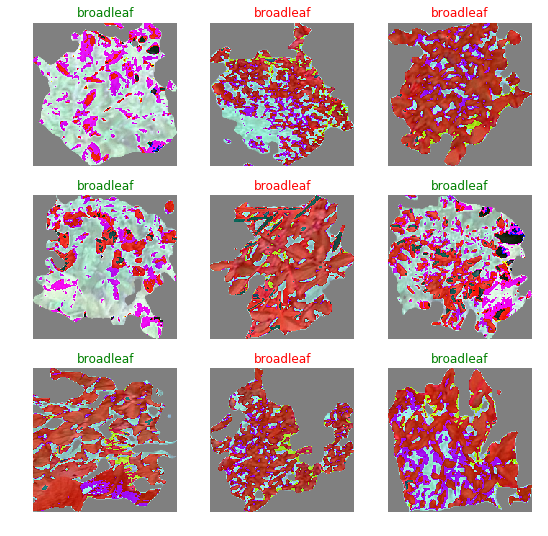

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


label_CM = {
    0: 'red',  # Incorrect classification
    1: 'green' # Correct classification
}

vl_indices = np.random.choice(len(y_test), 9)
vl_pred = []
vl_true = []

for idx in vl_indices:
    pred = net.predict(np.array([X_test[idx]]))
    vl_true.append(y_test[idx])
    vl_pred.append(pred)
vl_pred = np.array(vl_pred).flatten()

f,ax = plt.subplots(3, 3, figsize=(9, 9))
for idx in range(9):
    score = 1 if vl_pred[idx] == vl_true[idx] else 0
    class_type
    if idx in range(0,50):
      class_type = 'broadleaf'
    if idx in range(50,100):
      class_type = 'grass'
    if idx in range(100,150):
      class_type = 'soil'
    if idx in range(150,200):
      class_type = 'soybean'
    im_data = X_test[idx].reshape(im_width, im_height, im_channel).astype('uint8')
    ax[idx//3,idx%3].imshow(im_data, cmap='gray')
    ax[idx//3,idx%3].axis('off')
    ax[idx//3,idx%3].set_title(class_type, color=label_CM[score])